# Boson Sampling in Qiskit

The goal of this notebook is to try to do boson sampling on a universal quantum computer using a gate based circuit. For that, we will follow the procedure proposed in https://arxiv.org/pdf/1011.3245.pdf by Scott Aaronson and Alexander Akhipov.
The main idea is to see that any interferometer on m modes can be decomposed into $O(m^{2})$ 1 and 2 modes components (Bean Splitter and Phase Shifter basically). Then those components are easily convertible in a gate base circuit, using n qbit per modes
to encode up to $2^{n} - 1$ photons in each mode.

Such a Naive converter is implemented in the file component_converter of this repo. We will also try to evaluate the performances of such conversion and compare them to those of photonic architectures, which are natively doing boson sampling.

## Introduction

In [2]:
from math import pi, ceil, log2

import perceval as pcvl
from perceval import Circuit, BS, PS, BasicState
import qiskit
from qiskit import transpile
import qiskit_aer

from component_converter import NaiveBosonSamplingConverter

First, let see what the converter can do.

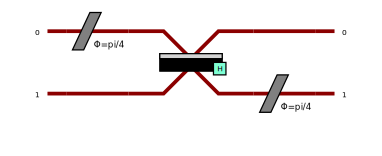

In [3]:
circuit = Circuit(2) // (0, PS(pi/4)) // BS.H() // (1, PS(pi/4))

pcvl.pdisplay(circuit)


C:\Users\MelvinMathe\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\circuit_visualization.py:346: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  image.show()


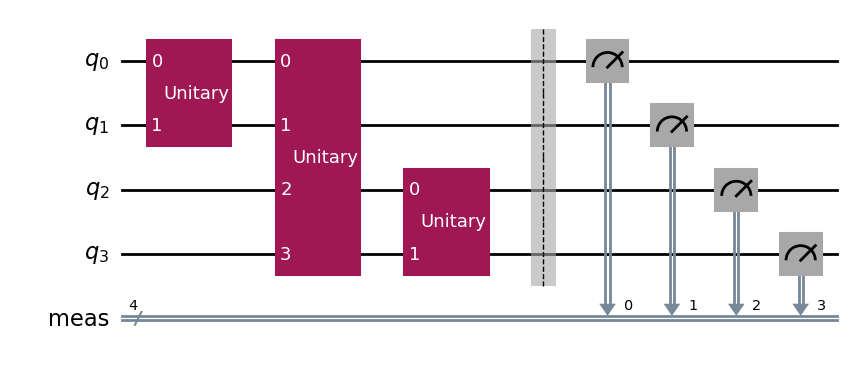

In [4]:
n_photon_max = 2
n_qbit = ceil(log2(n_photon_max + 1))
converter = NaiveBosonSamplingConverter(n_qbit)
converter.set_optical_circuit(circuit)

converter.qiskit_circuit.draw('mpl', interactive=True)

Those gates are just unitary transformations on 4 qubits, but there is no clue that they are easily constructible from a native set of gates of a real QPU. Let's try a transpilation on one of IBM's fake backend. 
This one has ["rz", "sx", "x", "cx"] as a basis gate

In [5]:
from qiskit.providers.fake_provider import Fake5QV1

t_circ = transpile(converter.qiskit_circuit, backend=Fake5QV1())

print(t_circ.depth())
print(dict(t_circ.count_ops()))

471
{'rz': 362, 'sx': 240, 'cx': 163, 'measure': 4, 'barrier': 1}


We see that the circuit is too deep to be reliable. Assuming the CNOT gates have a 98% chance of success (which would be very good), we only have a 3% chance of success for the whole circuit (considering the one qbit gates are perfect, which is not the case), and the interesting results would be hidden in noise.
Also, we already begin to see the problem : we need a very low error if we want the unitary to succeed.

From this point, let's focus on the simplest non-trivial case, the Hong-Ou-Mandel effect. So we have 2 modes, a beam splitter and 2 photons.

## Experiments

In [8]:
from qiskit_aer import AerSimulator
backend = AerSimulator()


circuit = BS.H()
converter = NaiveBosonSamplingConverter(2, backend=backend, circuit=circuit)
converter.set_input_state(BasicState([1, 1]))

samples = converter.sample(10000)

print(samples)

{'results': BSDistribution(<class 'float'>, {|0,2>: 0.4987, |2,0>: 0.5013}), 'logical_perf': 1, 'physical_perf': 1}


We see that we only sample $|2,0\rangle$ and $|0,2\rangle$ states, which confirm that the conversion is working. But obviously, with the perfect simulator, there is no errors.